# Mohr circle and stress paths

© 2022 Exneyder A. Montoya-Araque, Daniel F. Ruiz and Universidad EAFIT.

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/eamontoyaa/EAFIT_slope_stability/blob/main/notebooks/mohr_circles_and_stress_paths_simplified.ipynb).



## Required modules

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, widgets, fixed

## Global configuration for plots

In [17]:
plt.style.use("default")
# plt.rcParams["image.cmap"] = "brg"
# mpl.rcParams['axes.color_cycle'] = plt.get_cmap("brg")
mpl.rcParams.update(
    {
        "font.family": "serif",  # Use the Computer modern font
        "font.serif": "cmr10",
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)


# Funciones

In [18]:
def plot_mohr_circle(
    sigma_xx, sigma_yy, tau_xy, envelope={'c': 30, 'phi': 35}, plot_pole=False, plot_plane=False, alpha=0, xlim=(0, 20), ylim=(-7, 7)
):
    c = 0.5 * (sigma_xx + sigma_yy)
    r = np.sqrt((sigma_xx - c) ** 2 + tau_xy**2)
    sig_1 = r * np.cos(0) + c
    sig_3 = r * np.cos(np.pi) + c

    outcome = {
        "sig_1": sig_1,
        "sig_3": sig_3,
        "sig_xx": sigma_xx,
        "sig_yy": sigma_yy,
        "tau_xy": tau_xy,
        "s": 0.5 * (sig_1 + sig_3),
        "t": 0.5 * (sig_1 - sig_3),
        "p": 1 / 3 * (sig_1 + 2 * sig_3),
        "q": sig_1 - sig_3,
    }

    factor = 1.1
    theta = np.linspace(0, 2 * np.pi, 200)
    sigma = np.linspace(0, sig_1 * factor, 200)

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[6.5, 3.5])
    ax.axhline(y=0, xmin=0, xmax=sig_1 * factor, c="k")
    ax.plot(r * np.cos(theta) + c, r * np.sin(theta), c="k")  # Mohr circle

    label = "$\sigma_{1}=$" + f"{sig_1:.1f}"  # sigma_1
    ax.plot(sig_1, 0, ls="", c="#BB5566", marker=".", ms=12, label=label)
    label = "$\sigma_{3}=$" + f"{sig_3:.1f}"  # sigma_3
    ax.plot(sig_3, 0, ls="", c="#004488", marker=".", ms=12, label=label)
    label = "$\\tau_\mathrm{max}=$" + f"{r:.1f}"  # tau_max
    ax.plot(c, r, ls="", c="#cc3300", marker="P", ms=7, label=label)    
    # sigma_xx, tau_xy
    label = ("$\sigma_{xx}=$" + f"{sigma_xx:.1f}" + ", $\\tau_{xy}=$" + f"{tau_xy:.1f}")
    ax.plot(sigma_xx, tau_xy, ls="", c="#DDAA33", marker="s", label=label)
    # sigma_yy, (-)tau_xy
    label = ("$\sigma_{yy}=$" + f"{sigma_yy:.1f}" + ", $\\tau_{yx}=$" + f"{tau_xy:.1f}")
    ax.plot(sigma_yy, -1 * tau_xy, ls="", c="#117733", marker="s", label=label)

    # Failure envelope
    phi = envelope['phi']
    c = envelope['c']
    label = "$\\tau_\mathrm{n} = " + f"{c} + " + "\\tan" + f"{phi}^\circ" + "\sigma_\mathrm{n}$"
    ax.plot(sigma, c + np.tan(np.radians(phi)) * sigma, c="r", label=label)

    if plot_pole:  # Pole and stress on a plane 
        ax.axhline(y=-1 * tau_xy, c="b", ls="--", lw=0.75)
        ax.axvline(x=sigma_xx, c="b", ls="--", lw=0.75)
        ax.plot(sigma_xx, -1 * tau_xy, ls="", c="k",marker="o",label="Pole")
    if  plot_plane:
        # beta = 0.5 * np.degrees(np.arctan(tau_xy/sigma_xx))
        beta = np.degrees(np.arctan((sig_1 - sigma_xx)/tau_xy))
        theta = alpha + beta
        plane_sig_n = r * np.cos(np.radians(2 * theta)) + c
        plane_tau_n = r * np.sin(np.radians(2 * theta))
        label = (
            "Stress state on the plane\n" + "$\sigma_\mathrm{n}=$" + f"{plane_sig_n:.1f}"
            + ", $\\tau_\mathrm{n}=$" + f"{plane_tau_n:.1f}"
        )
        ax.plot(plane_sig_n, plane_tau_n, ls="", c="r", marker="o", label=label)
        ax.plot(
            (plane_sig_n, sigma_xx), (plane_tau_n, -1 * tau_xy), c="r", ls="--", lw=0.75,
            label=f"Plano a {alpha:.2f}" + "$^{\circ}$ del plano $\sigma_\mathrm{11}$"
        )

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.grid(True, ls="--")
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_linewidth(1.5)
    # ax.axis("equal")
    ax.set_aspect("equal", adjustable=None, anchor='C')
    ax.set(
        xlabel="Normal stress, $\sigma_\mathrm{n}\;[\mathrm{kPa}]$",
        ylabel="Shear stress, $\\tau_\mathrm{n}\;[\mathrm{kPa}]$",
        # xlim=(0, sig_1 * factor),
        xlim=xlim,
        # ylim=ylim
    )
    fig.tight_layout()
    return outcome


In [19]:
def plot_all_mohr_circles(stages, envelope={'c': 20, 'phi': 35}, xlim=(0, 200)):
    theta = np.linspace(0, 2 * np.pi, 200)
    # sigma = np.linspace(0, sig_1 * factor, 200)
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[6.5, 3.5])
    i = 0
    for st in stages:
        sigma_xx, sigma_yy, tau_xy = st['sig_xx'], st['sig_yy'], st['tau_xy']
        c = 0.5 * (sigma_xx + sigma_yy)
        r = np.sqrt((sigma_xx - c) ** 2 + tau_xy**2)
        sig_1 = r * np.cos(0) + c
        sig_3 = r * np.cos(np.pi) + c
        # ax.axhline(y=0, xmin=0, xmax=sig_1 * factor, c="k")
        ax.plot(r * np.cos(theta) + c, r * np.sin(theta), label=f'Stage {i}')  # Mohr circle
        i += 1
    # Failure envelope
    sigma = np.linspace(0, xlim[-1], 200)
    phi = envelope['phi']
    c = envelope['c']
    label = "$\\tau_\mathrm{n} = " + f"{c} + " + "\\tan" + f"{phi}^\circ" + "\sigma_\mathrm{n}$"
    ax.plot(sigma, c + np.tan(np.radians(phi)) * sigma, c="r", label=label)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.grid(True, ls="--")
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_linewidth(1.5)
    # ax.axis("equal")
    ax.set_aspect("equal", adjustable=None, anchor='C')
    ax.set(
        xlabel="Normal stress, $\sigma_\mathrm{n}\;[\mathrm{kg/cm^2}]$",
        ylabel="Shear stress, $\\tau_\mathrm{n}\;[\mathrm{kg/cm^2}]$",
        xlim=xlim)
    return



In [20]:
def plot_stress_path(stages, envelope={'c': 20, 'phi': 35}):
    # Mohr-Coulomb envelope
    phi = envelope['phi']
    phi_rad = np.radians(phi)
    c = envelope['c']
    sig_1, sig_3, s, t, p, q = [], [], [], [], [], []
    for st in stages:
        sig_1.append(st['sig_1'])
        sig_3.append(st['sig_3'])
        s.append(st['s'])
        t.append(st['t'])
        p.append(st['p'])
        q.append(st['q'])
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=[11, 4.0])
    # sigma_1, sigma_3
    ax0.plot(sig_3, sig_1, ls="--", c="k", marker="o", mfc = "tomato", lw=0.75)
    s_3 = np.linspace(0, max(sig_1)*1.5)
    s_1 = (s_3 * (1 +  np.sin(phi_rad)) + 2*c*np.cos(phi_rad) ) / (1 - np.sin(phi_rad))
    ax0.plot(
        s_3, s_1, c="#BB5566",
        label="Failure criterion: \n$\sigma_1' = \sigma_3' \\frac{(1 + \sin \phi')(2c' \cos \phi')}{1 - \sin \phi'}$",
        )
    ax0.set(
        xlabel="$\sigma'_{3}\;[\mathrm{kg/cm^2}]$", ylabel="$\sigma'_{1}\;[\mathrm{kg/cm^2}]$",
        xlim=(0, s_3.max()),
        # ylim=(0, 20)
    )
    # s, t
    ax1.plot(s, t, ls="--", c="k", marker="o", mfc = "tomato", lw=0.75)
    s3_plot = np.linspace(0, max(s)*1.5)
    ax1.plot(
        s3_plot, c * np.cos(phi_rad) + s3_plot * np.sin(np.arctan(phi_rad)), c="#004488",
        label="Failure criterion: \n$t = s'\,\sin \phi' + c' \sin \phi'$"
        )
    ax1.set(
        xlabel="$s'\;[\mathrm{kg/cm^2}]$", ylabel="$t\;[\mathrm{kg/cm^2}]$",
        xlim=(0, s3_plot.max()), 
        # ylim=(0, 8)
    )
    # p, q
    m = 6 * np.sin(np.arctan(phi_rad)) / (3 - np.sin(np.arctan(phi_rad)))
    a = c * 6 * np.cos(phi_rad) / (3-np.sin(phi_rad))
    p_plot = np.linspace(0, max(p)*1.5)
    ax2.plot(p, q, ls="--", c="k", marker="o", mfc = "tomato", lw=0.75)
    ax2.plot(p_plot , a + m * p_plot, c="#DDAA33",
            label="Failure criterion: \n$q = \\frac{6\sin \phi'}{3 - \sin \phi'} p' + \\frac{6\cos \phi'}{3 - \sin \phi'}$"
        )
    ax2.set(
        xlabel="$p\;[\mathrm{kg/cm^2}]$", ylabel="$q\;[\mathrm{kg/cm^2}]$",
        xlim=(0, p_plot.max()),
        # ylim=(0, 14)
    )

    for ax in (ax0, ax1, ax2):
        ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))
        ax.grid(True, ls=":")
        ax.spines["bottom"].set_linewidth(1.5)
        ax.spines["left"].set_linewidth(1.5)
        
    fig.tight_layout()


# Herramienta No. 1

Estado de esfuerzos en la misma etapa para diferentes puntos.

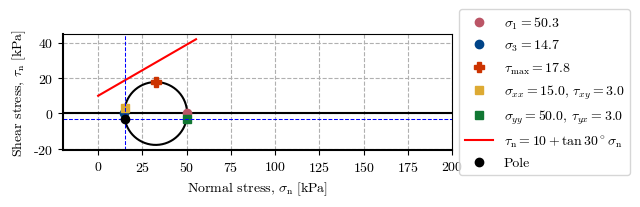

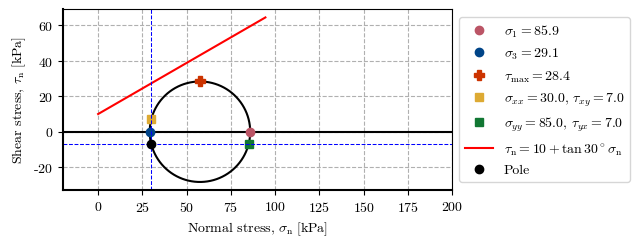

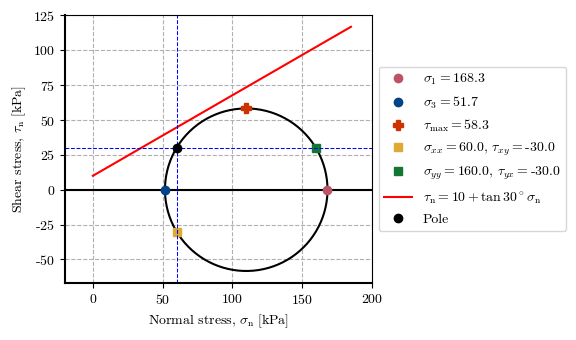

In [21]:
slope1_ptX_stage3 = plot_mohr_circle(sigma_xx=15, sigma_yy=50, tau_xy=3, envelope={'c': 10, 'phi': 30}, xlim=(-20, 200), plot_pole=True)
slope1_ptY_stage3 = plot_mohr_circle(sigma_xx=30, sigma_yy=85, tau_xy=7, envelope={'c': 10, 'phi': 30}, xlim=(-20, 200), plot_pole=True)
slope1_ptZ_stage3 = plot_mohr_circle(sigma_xx=60, sigma_yy=160, tau_xy=-30, envelope={'c': 10, 'phi': 30}, xlim=(-20, 200), plot_pole=True)

# Herramienta No. 2

Estado de esfuerzos en el mismo punto para diferentes etapas.

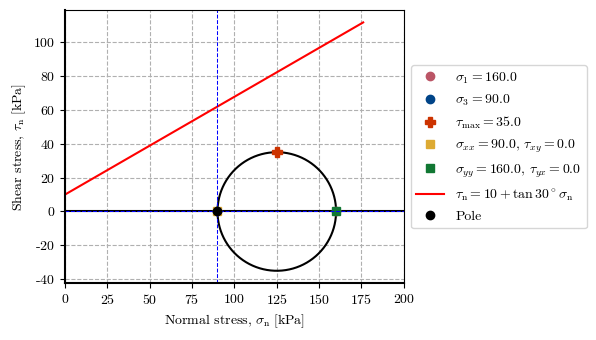

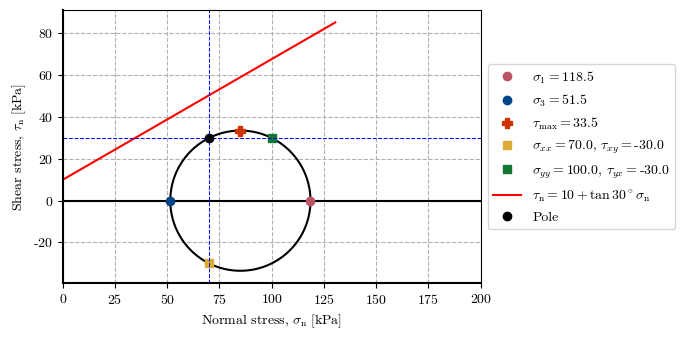

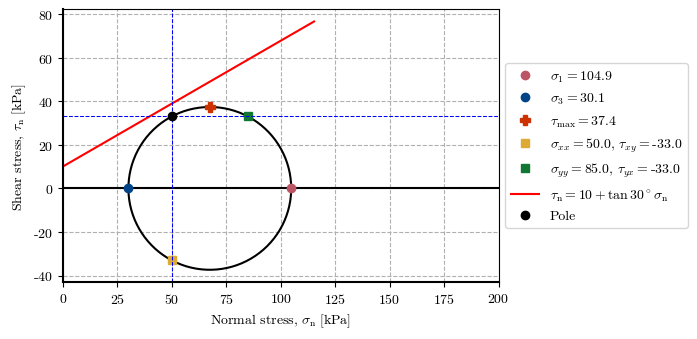

In [22]:
slope1_ptX_stage1 = plot_mohr_circle(sigma_xx=90, sigma_yy=160, tau_xy=0, envelope={'c': 10, 'phi': 30}, xlim=(0, 200), plot_pole=True)
slope1_ptX_stage2 = plot_mohr_circle(sigma_xx=70, sigma_yy=100, tau_xy=-30, envelope={'c': 10, 'phi': 30}, xlim=(0, 200), plot_pole=True)
slope1_ptX_stage3 = plot_mohr_circle(sigma_xx=50, sigma_yy=85, tau_xy=-33, envelope={'c': 10, 'phi': 30}, xlim=(0, 200), plot_pole=True)

# Herramienta No. 3
Trayectorias de tensiones

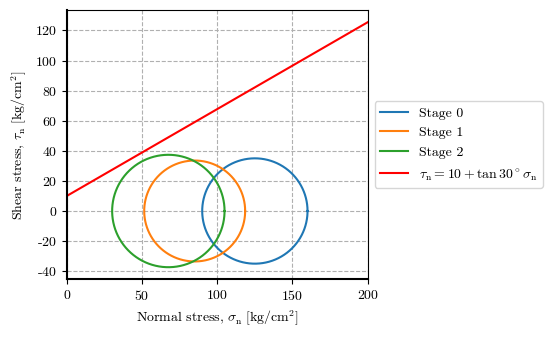

In [23]:
stages = (slope1_ptX_stage1, slope1_ptX_stage2, slope1_ptX_stage3)
plot_all_mohr_circles(stages, envelope={'c': 10, 'phi': 30}, xlim=(0, 200))

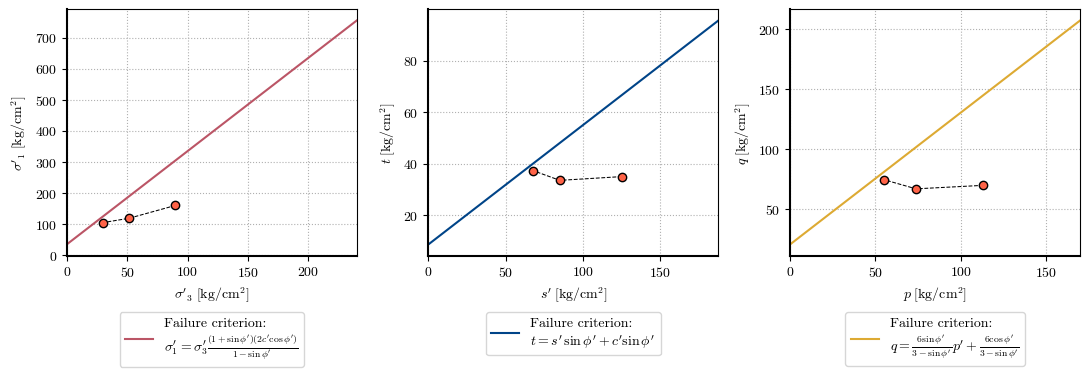

In [24]:
stages = (slope1_ptX_stage1, slope1_ptX_stage2, slope1_ptX_stage3)
plot_stress_path(stages, envelope={'c': 10, 'phi': 30})